In [1]:
import numpy as np

import mne
mne.set_log_level(verbose='CRITICAL')
from mne.datasets import multimodal
from mne import channels, evoked, create_info
import matplotlib.pyplot as plt

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
tf.get_logger().setLevel('ERROR')
tf.autograph.set_verbosity(0)

import mneflow
import scipy.signal as sl
from typing import Optional


fname_raw = os.path.join(multimodal.data_path(), 'multimodal_raw.fif')
raw = mne.io.read_raw_fif(fname_raw)

cond = raw.acqparser.get_condition(raw, None)
# get the list of condition names
condition_names = [k for c in cond for k,v in c['event_id'].items()]
epochs_list = [mne.Epochs(raw, **c) for c in cond]
epochs = mne.concatenate_epochs(epochs_list)
epochs = epochs.pick_types(meg='grad')
print(epochs.info)

<Info | 22 non-empty values
 acq_pars: ACQch001 110113 ACQch002 110112 ACQch003 110111 ACQch004 110122 ...
 acq_stim: 5 10.000000 500.000000 6 10.000000 500.000000
 bads: []
 ch_names: MEG 0113, MEG 0112, MEG 0122, MEG 0123, MEG 0132, MEG 0133, MEG ...
 chs: 204 Gradiometers
 custom_ref_applied: False
 description: Vectorview system at BioMag
 dev_head_t: MEG device -> head transform
 dig: 21 items (3 Cardinal, 4 HPI, 14 Extra)
 events: 1 item (list)
 experimenter: neuromag
 file_id: 4 items (dict)
 highpass: 0.1 Hz
 hpi_meas: 1 item (list)
 hpi_results: 1 item (list)
 lowpass: 172.2 Hz
 meas_date: 2011-04-26 11:33:18 UTC
 meas_id: 4 items (dict)
 nchan: 204
 proj_id: 1 item (ndarray)
 proj_name: test
 projs: grad_ssp_upright.fif : PCA-v1: on, grad_ssp_upright.fif : ...
 sfreq: 600.6 Hz
 subject_info: 9 items (dict)
>


In [2]:
condition_names

['Visual Upper right',
 'Visual Lower right',
 'Visual Lower left',
 'Visual Upper left',
 'Somato right',
 'Somato left',
 'Auditory right',
 'Auditory left']

In [2]:
from mneflow.layers import LFTConv, DeMixing, Dense
from tensorflow.keras.layers import Dropout

class SimpleNet(mneflow.models.LFCNN):
    def __init__(self, Dataset, specs=None):
        if specs is None:
            specs=dict()
        super().__init__(Dataset, specs)

    def build_graph(self):
        self.dmx = DeMixing(size=self.specs['n_latent'], nonlin=tf.identity,
                            axis=3, specs=self.specs)
        self.dmx_out = self.dmx(self.inputs)

        self.tconv = LFTConv(
            size=self.specs['n_latent'],
            nonlin=self.specs['nonlin'],
            filter_length=self.specs['filter_length'],
            padding=self.specs['padding'],
            specs=self.specs
        )
        self.tconv_out = self.tconv(self.dmx_out)

        self.envconv = LFTConv(
            size=self.specs['n_latent'],
            nonlin=self.specs['nonlin'],
            filter_length=self.specs['filter_length'],
            padding=self.specs['padding'],
            specs=self.specs
        )

        self.envconv_out = self.envconv(self.tconv_out)
        self.pool = lambda X: X[:, :, ::self.specs['pooling'], :]

        self.pooled = self.pool(self.envconv_out)

        dropout = Dropout(
            self.specs['dropout'],
            noise_shape=None
        )(self.pooled)

        self.fin_fc = Dense(size=self.out_dim, nonlin=tf.identity,
                            specs=self.specs)

        y_pred = self.fin_fc(dropout)

        return y_pred

    def compute_patterns(self, data_path=None, *, output='patterns'):

        if not data_path:
            print("Computing patterns: No path specified, using validation dataset (Default)")
            ds = self.dataset.val
        elif isinstance(data_path, str) or isinstance(data_path, (list, tuple)):
            ds = self.dataset._build_dataset(
                data_path,
                split=False,
                test_batch=None,
                repeat=True
            )
        elif isinstance(data_path, mneflow.data.Dataset):
            if hasattr(data_path, 'test'):
                ds = data_path.test
            else:
                ds = data_path.val
        elif isinstance(data_path, tf.data.Dataset):
            ds = data_path
        else:
            raise AttributeError('Specify dataset or data path.')

        X, y = [row for row in ds.take(1)][0]

        self.out_w_flat = self.fin_fc.w.numpy()
        self.out_weights = np.reshape(
            self.out_w_flat,
            [-1, self.dmx.size, self.out_dim]
        )
        self.out_biases = self.fin_fc.b.numpy()
        self.feature_relevances = self.componentwise_loss(X, y)
        self.branchwise_loss(X, y)

        # compute temporal convolution layer outputs for vis_dics
        tc_out = self.pool(self.tconv(self.dmx(X)).numpy())

        # compute data covariance
        X = X - tf.reduce_mean(X, axis=-2, keepdims=True)
        X = tf.transpose(X, [3, 0, 1, 2])
        X = tf.reshape(X, [X.shape[0], -1])
        self.dcov = tf.matmul(X, tf.transpose(X))

        # get spatial extraction fiter weights
        demx = self.dmx.w.numpy()

        kern = np.squeeze(self.tconv.filters.numpy()).T

        X = X.numpy().T

        patterns = []
        X_filt = np.zeros_like(X)
        for i_comp in range(kern.shape[0]):
            for i_ch in range(X.shape[1]):
                x = X[:, i_ch]
                X_filt[:, i_ch] = np.convolve(x, kern[i_comp, :], mode="same")
            patterns.append(np.cov(X_filt.T) @ demx[:, i_comp])
        self.patterns = np.array(patterns).T


        if 'patterns' in output:
            if 'old' in output:
                self.patterns = np.dot(self.dcov, demx)
            else:
                patterns = []
                X_filt = np.zeros_like(X)
                for i_comp in range(kern.shape[0]):
                    for i_ch in range(X.shape[1]):
                        x = X[:, i_ch]
                        X_filt[:, i_ch] = np.convolve(x, kern[i_comp, :], mode="same")
                    patterns.append(np.cov(X_filt.T) @ demx[:, i_comp])
                self.patterns = np.array(patterns).T
        else:
            self.patterns = demx

        self.lat_tcs = np.dot(demx.T, X.T)

        del X

        #  Temporal conv stuff
        self.filters = kern.T
        self.tc_out = np.squeeze(tc_out)
        self.corr_to_output = self.get_output_correlations(y)

    def plot_patterns(
        self, sensor_layout=None, sorting='l2', percentile=90,
        scale=False, class_names=None, info=None
    ):
        order, ts = self._sorting(sorting)
        self.uorder = order.ravel()
        l_u = len(self.uorder)
        if info:
            info.__setstate__(dict(_unlocked=True))
            info['sfreq'] = 1.
            self.fake_evoked = evoked.EvokedArray(self.patterns, info, tmin=0)
            if l_u > 1:
                self.fake_evoked.data[:, :l_u] = self.fake_evoked.data[:, self.uorder]
            elif l_u == 1:
                self.fake_evoked.data[:, l_u] = self.fake_evoked.data[:, self.uorder[0]]
            self.fake_evoked.crop(tmax=float(l_u))
            if scale:
                _std = self.fake_evoked.data[:, :l_u].std(0)
                self.fake_evoked.data[:, :l_u] /= _std
        elif sensor_layout:
            lo = channels.read_layout(sensor_layout)
            info = create_info(lo.names, 1., sensor_layout.split('-')[-1])
            orig_xy = np.mean(lo.pos[:, :2], 0)
            for i, ch in enumerate(lo.names):
                if info['chs'][i]['ch_name'] == ch:
                    info['chs'][i]['loc'][:2] = (lo.pos[i, :2] - orig_xy)/3.
                    #info['chs'][i]['loc'][4:] = 0
                else:
                    print("Channel name mismatch. info: {} vs lo: {}".format(
                        info['chs'][i]['ch_name'], ch))

            self.fake_evoked = evoked.EvokedArray(self.patterns, info)

            if l_u > 1:
                self.fake_evoked.data[:, :l_u] = self.fake_evoked.data[:, self.uorder]
            elif l_u == 1:
                self.fake_evoked.data[:, l_u] = self.fake_evoked.data[:, self.uorder[0]]
            self.fake_evoked.crop(tmax=float(l_u))
            if scale:
                _std = self.fake_evoked.data[:, :l_u].std(0)
                self.fake_evoked.data[:, :l_u] /= _std
        else:
            raise ValueError("Specify sensor layout")


        if np.any(self.uorder):
            nfilt = max(self.out_dim, 8)
            nrows = max(1, l_u//nfilt)
            ncols = min(nfilt, l_u)
            f, ax = plt.subplots(nrows, ncols, sharey=True)
            plt.tight_layout()
            f.set_size_inches([16, 3])
            ax = np.atleast_2d(ax)

            for ii in range(nrows):
                fake_times = np.arange(ii * ncols,  (ii + 1) * ncols, 1.)
                vmax = np.percentile(self.fake_evoked.data[:, :l_u], 95)
                self.fake_evoked.plot_topomap(
                    times=fake_times,
                    axes=ax[ii],
                    colorbar=False,
                    vmax=vmax,
                    scalings=1,
                    time_format="Branch #%g",
                    title='Patterns ('+str(sorting)+')',
                    outlines='head',
                )

    def branchwise_loss(self, X, y):
        model_weights_original = self.km.get_weights().copy()
        base_loss, _ = self.km.evaluate(X, y, verbose=0)

        losses = []
        for i in range(self.specs["n_latent"]):
            model_weights = model_weights_original.copy()
            spatial_weights = model_weights[0].copy()
            spatial_biases = model_weights[1].copy()
            temporal_biases = model_weights[3].copy()
            env_biases = model_weights[5].copy()
            spatial_weights[:, i] = 0
            spatial_biases[i] = 0
            temporal_biases[i] = 0
            env_biases[i] = 0
            model_weights[0] = spatial_weights
            model_weights[1] = spatial_biases
            model_weights[3] = temporal_biases
            model_weights[5] = env_biases
            self.km.set_weights(model_weights)
            losses.append(self.km.evaluate(X, y, verbose=0)[0])
        self.km.set_weights(model_weights_original)
        self.branch_relevance_loss = base_loss - np.array(losses)

    def plot_branch(
        self,
        branch_num: int,
        info: mne.Info,
        params: Optional[list[str]] = ['input', 'output', 'response']
    ):
        info.__setstate__(dict(_unlocked=True))
        info['sfreq'] = 1.
        sorting = np.argsort(self.branch_relevance_loss)[::-1]
        data = self.patterns[:, sorting]
        filters = self.filters[:, sorting]
        relevances = self.branch_relevance_loss - self.branch_relevance_loss.min()
        relevance = sorted([np.round(rel/relevances.sum(), 2) for rel in relevances], reverse=True)[branch_num]
        self.fake_evoked = evoked.EvokedArray(data, info, tmin=0)
        fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1)
        fig.tight_layout()

        self.fs = self.dataset.h_params['fs']

        out_filter = filters[:, branch_num]
        _, psd = sl.welch(self.lat_tcs[branch_num], fs=self.fs, nperseg=self.fs * 2)
        w, h = (lambda w, h: (w, h))(*sl.freqz(out_filter, 1, worN=self.fs))
        frange = w / np.pi * self.fs / 2
        z = lambda x: (x - x.mean())/x.std()

        for param in params:
            if param == 'input':
                finput = psd[:-1]
                finput = z(finput)
                ax2.plot(frange, finput - finput.min(), color='tab:blue')
            elif param == 'output':
                foutput = np.real(finput * h * np.conj(h))
                foutput = z(foutput)
                ax2.plot(frange, foutput - foutput.min(), color='tab:orange')
            elif param == 'response':
                fresponce = np.abs(h)
                fresponce = z(fresponce)
                ax2.plot(frange, fresponce - fresponce.min(), color='tab:green')
            elif param == 'pattern':
                fpattern = finput * np.abs(h)
                fpattern = z(fpattern)
                ax2.plot(frange, fpattern - fpattern.min(), color='tab:pink')

        ax2.legend([param.capitalize() for param in params])
        ax2.set_xlim(0, 100)

        fig.suptitle(f'Branch {branch_num}', y=0.95, x=0.2, fontsize=30)
        fig.set_size_inches(10, 5)
        self.fake_evoked.plot_topomap(
            times=branch_num,
            axes=ax1,
            colorbar=False,
            scalings=1,
            time_format="",
            outlines='head',
        )

        return fig


In [3]:
from tensorflow.keras import layers
from mneflow.layers import LFTConv, DeMixing, Dense
from tensorflow.keras.layers import Dropout

class SimpleNetT(SimpleNet):
    def __init__(self, Dataset, specs=None):
        if specs is None:
            specs=dict()
        super().__init__(Dataset, specs)

    def transformer_encoder_block(self, inputs):
        # Normalization and Attention
        x = layers.LayerNormalization(epsilon=1e-6)(inputs)
        x = layers.MultiHeadAttention(
            key_dim=self.specs['transformer_params']['head_size'],
            num_heads=self.specs['transformer_params']['num_heads'],
            dropout=self.specs['transformer_params']['dropout']
        )(x, x)
        x = layers.Dropout(self.specs['transformer_params']['dropout'])(x)
        res = x + inputs

        # Feed Forward Part
        x = layers.LayerNormalization(epsilon=1e-6)(res)
        x = layers.Conv1D(filters=self.specs['transformer_params']['ff_dim'], kernel_size=1, activation="relu")(x)
        x = layers.Dropout(self.specs['transformer_params']['dropout'])(x)
        x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)

        return x + res

    def build_graph(self):
        self.dmx = DeMixing(size=self.specs['n_latent'], nonlin=tf.identity,
                            axis=3, specs=self.specs)
        self.dmx_out = self.dmx(self.inputs)

        self.tconv = LFTConv(
            size=self.specs['n_latent'],
            nonlin=self.specs['nonlin'],
            filter_length=self.specs['filter_length'],
            padding=self.specs['padding'],
            specs=self.specs
        )
        self.tconv_out = self.tconv(self.dmx_out)

        self.envconv = LFTConv(
            size=self.specs['n_latent'],
            nonlin=self.specs['nonlin'],
            filter_length=self.specs['filter_length'],
            padding=self.specs['padding'],
            specs=self.specs
        )

        self.envconv_out = self.envconv(self.tconv_out)
        self.pool = lambda X: X[:, :, ::self.specs['pooling'], :]

        self.pooled = self.pool(self.envconv_out)

        dropout = Dropout(
            self.specs['dropout'],
            noise_shape=None
        )(self.pooled)

        x = dropout

        for _ in range(self.specs['transformer_params']['num_transformer_blocks']):
            x = self.transformer_encoder_block(x)
        x = layers.GlobalAveragePooling1D(data_format="channels_first")(tf.squeeze(x, axis=1))
        for dim in self.specs['transformer_params']['mlp_units']:
            x = layers.Dense(dim, activation="relu")(x)
            x = layers.Dropout(self.specs['transformer_params']['mlp_dropout'])(x)

        self.fin_fc = Dense(size=self.out_dim, nonlin=tf.identity,
                            specs=self.specs)
        y_pred = self.fin_fc(dropout)

        return y_pred

In [5]:
#Specify import options
import_opt = dict(
    savepath='../TFR/',  # path where TFR files will be saved
    out_name='mne_sample_epochs',  # name of TFRecords files
    fs=600,
    input_type='trials',
    target_type='int',
    picks={'meg':'grad'},
    scale=True,  # apply baseline_scaling
    crop_baseline=True,  # remove baseline interval after scaling
    decimate=None,
    scale_interval=(0, 60),  # indices in time axis corresponding to baseline interval
    n_folds=5,  # validation set size set to 20% of all data
    overwrite=True,
    segment=False,
    test_set='holdout'
)


#write TFRecord files and metadata file to disk
meta = mneflow.produce_tfrecords(epochs, **import_opt)

dataset = mneflow.Dataset(meta, train_batch=100)

processing epochs
Converting picks
input shapes: X: (940, 204, 361) targets: (940,)
(940,)
Preprocessing:
Scaling to interval 0.0 - 60.0
n: 940
Splitting into: 6 folds x 156
Preprocessed: (940, 1, 301, 204) (940, 1) folds: 6 x 156
Prepocessed sample shape: (1, 301, 204)
Target shape actual/metadata:  (8,) (8,)
Saving TFRecord# 0


In [21]:
lf_params = dict(
    n_latent=16, #number of latent factors
    filter_length=50, #convolutional filter length in time samples
    nonlin = tf.nn.relu,
    padding = 'SAME',
    pooling = 5,#pooling factor
    stride = 5, #stride parameter for pooling layer
    pool_type='max',
    model_path = import_opt['savepath'],
    dropout = .5,
    l1_scope = ["weights"],
    l1=3e-3,
    transformer_params = dict(
        head_size=256,
        num_heads=14,
        ff_dim=40,
        num_transformer_blocks=20,
        mlp_units=[128],
        mlp_dropout=0.4,
        dropout=0.25,
    )
)

model = SimpleNetT(dataset, lf_params)
model.build()

Setting reg for dmx, to l1
Built: dmx input: (None, 1, 301, 204)
Setting reg for tconv, to l1
Built: tconv input: (None, 1, 301, 16)
Setting reg for tconv, to l1
Built: tconv input: (None, 1, 301, 16)
Setting reg for fc, to l1
Built: fc input: (None, 1, 61, 16)
Input shape: (1, 301, 204)
y_pred: (None, 8)
Initialization complete!


In [11]:
# specify model parameters
lf_params = dict(
    n_latent=16, #number of latent factors
    filter_length=50, #convolutional filter length in time samples
    nonlin = tf.nn.relu,
    padding = 'SAME',
    pooling = 5,#pooling factor
    stride = 5, #stride parameter for pooling layer
    pool_type='max',
    model_path = import_opt['savepath'],
    dropout = .5,
    l1_scope = ["weights"],
    l1=3e-3
)

model = SimpleNet(dataset, lf_params)
model.build()

Setting reg for dmx, to l1
Built: dmx input: (None, 1, 301, 204)
Setting reg for tconv, to l1
Built: tconv input: (None, 1, 301, 16)
Setting reg for tconv, to l1
Built: tconv input: (None, 1, 301, 16)
Setting reg for fc, to l1
Built: fc input: (None, 1, 61, 16)
Input shape: (1, 301, 204)
y_pred: (None, 8)
Initialization complete!


Class weights:  None
Epoch 1/25
100/100 - 5s - loss: 2.0666 - cat_ACC: 0.1573 - val_loss: 2.0710 - val_cat_ACC: 0.0985 - 5s/epoch - 50ms/step
Epoch 2/25
100/100 - 3s - loss: 1.8346 - cat_ACC: 0.2719 - val_loss: 1.7325 - val_cat_ACC: 0.3106 - 3s/epoch - 33ms/step
Epoch 3/25
100/100 - 3s - loss: 1.3696 - cat_ACC: 0.4904 - val_loss: 1.3106 - val_cat_ACC: 0.5227 - 3s/epoch - 33ms/step
Epoch 4/25
100/100 - 3s - loss: 0.9857 - cat_ACC: 0.6466 - val_loss: 1.0103 - val_cat_ACC: 0.6515 - 3s/epoch - 32ms/step
Epoch 5/25
100/100 - 3s - loss: 0.6775 - cat_ACC: 0.7648 - val_loss: 0.8144 - val_cat_ACC: 0.7197 - 3s/epoch - 31ms/step
Epoch 6/25
100/100 - 3s - loss: 0.4738 - cat_ACC: 0.8405 - val_loss: 0.7106 - val_cat_ACC: 0.7500 - 3s/epoch - 32ms/step
Epoch 7/25
100/100 - 3s - loss: 0.3465 - cat_ACC: 0.8859 - val_loss: 0.6353 - val_cat_ACC: 0.8030 - 3s/epoch - 32ms/step
Epoch 8/25
100/100 - 3s - loss: 0.2494 - cat_ACC: 0.9177 - val_loss: 0.5893 - val_cat_ACC: 0.8106 - 3s/epoch - 32ms/step
Epoch 9/25


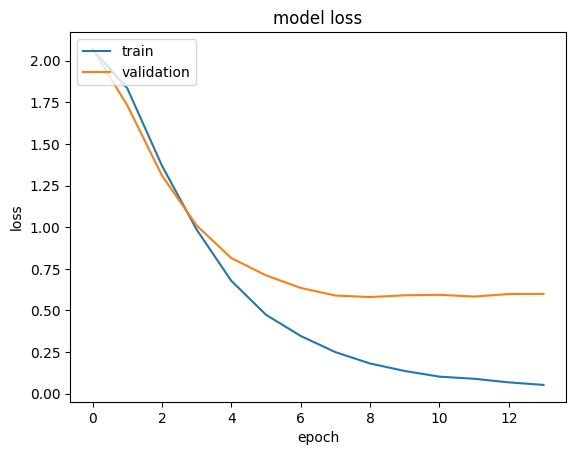

In [22]:
model.train(n_epochs=25, eval_step=100, early_stopping=5)
model.plot_hist()

In [20]:
test_loss, test_acc = model.evaluate(meta['test_paths'])
test_acc

0.807692289352417

Computing patterns: No path specified, using validation dataset (Default)


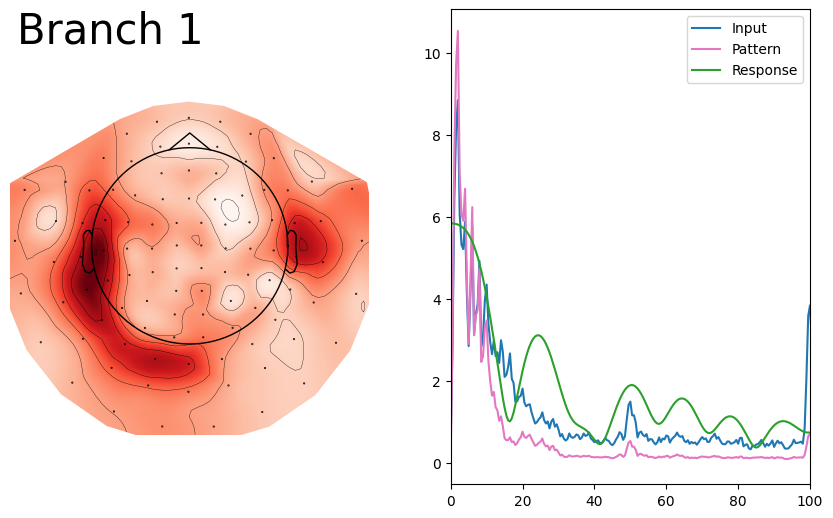

In [36]:
model.compute_patterns_ossadtchi()
fig = model.plot_branch(1, epochs.info, params=['input', 'pattern', 'response'])

Computing patterns: No path specified, using validation dataset (Default)


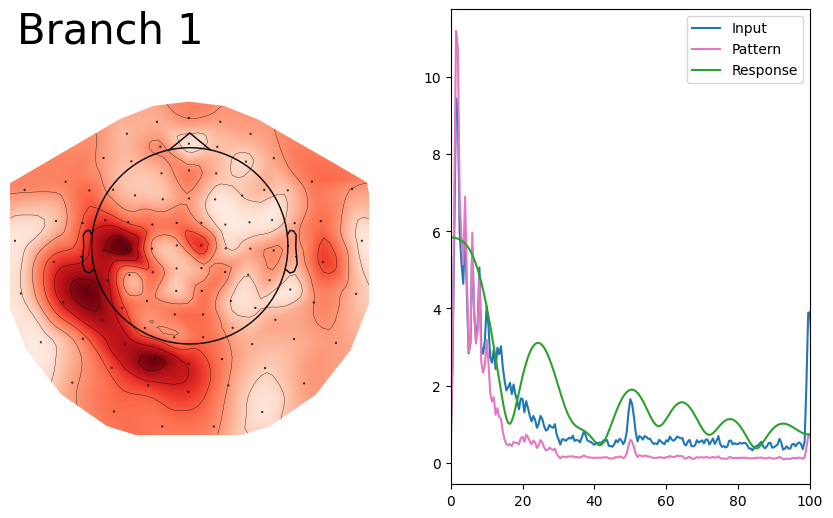

In [37]:
model.compute_patterns_ossadtchi(output='patterns old')
fig = model.plot_branch(1, epochs.info, params=['input', 'pattern', 'response'])